In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader

In [45]:
class RBM(nn.Module):
    
    def __init__(self, visible_units = 50, hidden_units = 10, k=1, batch_size = 128, learning_rate = 1e-5, 
                 learning_rate_decay = False, increase_to_cd_k = False, device ='cpu'):
        
        super(RBM, self).__init__()
        self.desc = "RBM"
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.increase_to_cd_k = increase_to_cd_k
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.device = device
        
        self.activation = torch.nn.Sigmoid()
        self.activation_name = self.activation.__class__.__name__.lower()
        self.weight = nn.Parameter(torch.rand(self.visible_units, self.hidden_units, device = self.device))
        self.v_bias = nn.Parameter(torch.rand(self.visible_units, device = self.device))
        #self.h_bias = nn.Parameter(torch.rand(self.visible_units, device = self.device))
        self.h_bias = nn.Parameter(torch.rand(self.hidden_units, device = self.device))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight, nn.init.calculate_gain(self.activation_name))
        nn.init.zeros_(self.v_bias)
        nn.init.zeros_(self.h_bias)
        
    def to_hidden(self, vis_prob):
        hid_prob = torch.matmul(vis_prob, self.weight)
        hid_prob = torch.add(hid_prob, self.h_bias)
        hid_prob = self.activation(hid_prob)
        hid_sample = torch.bernoulli(hid_prob)
        return hid_prob, hid_sample
    
    def to_visible(self, hid_prob):
        vis_prob_recon = torch.matmul(hid_prob,self.weight.t())
        vis_prob_recon = torch.add(vis_prob_recon, self.v_bias)
        vis_prob_recon = self.activation(vis_prob_recon)
        vis_sample = torch.bernoulli(vis_prob_recon)
        return vis_prob_recon, vis_sample
    
    #def reconstruction_error(self, data):
     #   return self.contrastive_divergence(data, False)
    
    def reconstruct(self, vis_prob, n_gibbs):
        vis_sample = torch.rand(vis_prob.size(), device=self.device)
        for i in range(n_gibbs):
            hid_prob, hid_sample = self.to_hidden(vis_prob)
            vis_prob, vis_sample = self.to_visible(hid_prob)
        return vis_prob, vis_sample
    
    def contrastive_divergence(self, input_data, training = True, n_gibbs_sampling_steps =1, lr = 0.001):
        #positive phase
        positive_hid_prob, positive_hid_dis = self.to_hidden(input_data)
        
        #calc energy via positive side
        positive_associations = torch.matmul(input_data.t(), positive_hid_dis)
        
        #Negative Phase
        hidden_activations = positive_hid_dis
        vis_probvis_prob = torch.rand(input_data.size(), device=self.device)
        hid_prob = torch.rand(positive_hid_prob.size(), device=self.device)
        
        for i in range(n_gibbs_sampling_steps):
            vis_prob, _ = self.to_visible(hidden_activations)
            hid_prob, hidden_activations = self.to_hidden(vis_prob)
        
        negative_vis_prob = vis_prob
        negative_hid_prob = hid_prob
        
        #Calculating w via negative side.
        negative_associations = torch.matmul(negative_vis_prob.t(), negative_hid_prob)
        
        # Update parameters
        grad_update = 0
        if training:
            batch_size = self.batch_size
            g = positive_associations - negative_associations
            grad_update = g / batch_size
            v_bias_update = (torch.sum(input_data - negative_vis_prob, dim=0) /
                             batch_size)
            h_bias_update = torch.sum(positive_hid_prob - negative_hid_prob,
                                      dim=0) / batch_size

            # Attention: While applying in-place operation to a leaf Variable,
            # .data should be added.
            
            self.weight.data += lr * grad_update
            self.v_bias.data += lr * v_bias_update
            self.h_bias.data += lr * h_bias_update

        # Compute reconstruction mse error
        error = torch.mean(torch.sum(
            (input_data - negative_vis_prob) ** 2, dim=0)).item()
        
        return error, torch.sum(torch.abs(grad_update)).item()
    
    def forward(self, input_data):
        return self.to_hidden(input_data)

    def step(self, input_data, epoch_i, epoch):
        
        # Gibbs_sampling step gradually increases to k as the train processes.
        if self.increase_to_cd_k:
            n_gibbs_sampling_steps = int(math.ceil((epoch_i / epoch) * self.k))
        else:
            n_gibbs_sampling_steps = self.k

        if self.learning_rate_decay:
            lr = self.learning_rate / epoch_i
        else:
            lr = self.learning_rate
        return self.contrastive_divergence(input_data, True, n_gibbs_sampling_steps, lr)

    
    def train_rbm(self, train_dataloader, epoch=50):

        if isinstance(train_dataloader, DataLoader):
            train_loader = train_dataloader
        else:
            raise TypeError('train_dataloader is not a dataloader instance.')

        for epoch_i in range(1, epoch + 1):
            n_batches = int(len(train_loader))

            cost_ = torch.FloatTensor(n_batches, 1)
            grad_ = torch.FloatTensor(n_batches, 1)

            # Train_loader contains input and output data. However, training
            # of RBM doesn't require output data.
            for i, batch in enumerate(train_loader):
                cost_[i - 1], grad_[i - 1] = self.step(batch[0], epoch_i, epoch)
            print('Epoch:{0}/{1} -rbm_train_loss: {2:.3f}'.format(epoch_i, epoch, torch.mean(cost_)))

        return
    

In [46]:
import warnings
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import Adam, SGD

In [47]:
class DBN(nn.Module):
    def __init__(self, hidden_units, visible_units=256, output_units=1, k=2,learning_rate=1e-5, learning_rate_decay=False,
                 increase_to_cd_k=False, device='cpu'):
        
        super(DBN, self).__init__()
        self.n_layers = len(hidden_units)
        self.rbm_layers = []
        self.rbm_nodes = []
        self.device = device
        self.is_pretrained = False
        self.is_finetune = False

        # Creating different RBM layers
        for i in range(self.n_layers):
            if i == 0:
                input_size = visible_units
            else:
                input_size = hidden_units[i - 1]
            rbm = RBM(visible_units=input_size, hidden_units=hidden_units[i],k=k, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                      increase_to_cd_k=increase_to_cd_k, device=device)

            self.rbm_layers.append(rbm)

        self.W_rec = [self.rbm_layers[i].weight for i in range(self.n_layers)]
        self.bias_rec = [self.rbm_layers[i].h_bias for i in range(self.n_layers)]

        for i in range(self.n_layers):
            self.register_parameter('W_rec%i' % i, self.W_rec[i])
            self.register_parameter('bias_rec%i' % i, self.bias_rec[i])

        self.bpnn = torch.nn.Linear(hidden_units[-1], output_units).to(self.device)

    def forward(self, input_data):

        v = input_data.to(self.device)
        hid_output = v.clone()
        for i in range(len(self.rbm_layers)):
            hid_output, _ = self.rbm_layers[i].to_hidden(hid_output)
        output = self.bpnn(hid_output)
        return output

    def reconstruct(self, input_data):

        h = input_data.to(self.device)
        p_h = 0
        for i in range(len(self.rbm_layers)):
            # h = h.view((h.shape[0], -1))
            p_h, h = self.rbm_layers[i].to_hidden(h)

        for i in range(len(self.rbm_layers) - 1, -1, -1):
            # h = h.view((h.shape[0], -1))
            p_h, h = self.rbm_layers[i].to_visible(h)
        return p_h, h

    def pretrain(self, x, epoch=50, batch_size=10):

        hid_output_i = torch.tensor(x, dtype=torch.float, device=self.device)

        for i in range(len(self.rbm_layers)):
            print("Training rbm layer {}.".format(i + 1))

            dataset_i = TensorDataset(hid_output_i)
            dataloader_i = DataLoader(dataset_i, batch_size=batch_size, drop_last=False)

            self.rbm_layers[i].train_rbm(dataloader_i, epoch)
            hid_output_i, _ = self.rbm_layers[i].forward(hid_output_i)

        # Set pretrain finish flag.
        self.is_pretrained = True
        return

    def pretrain_single(self, x, layer_loc, epoch, batch_size):

        if layer_loc > len(self.rbm_layers) or layer_loc <= 0:
            raise ValueError('Layer index out of range.')
        ith_layer = layer_loc - 1
        hid_output_i = torch.tensor(x, dtype=torch.float, device=self.device)

        for ith in range(ith_layer):
            hid_output_i, _ = self.rbm_layers[ith].forward(hid_output_i)

        dataset_i = TensorDataset(hid_output_i)
        dataloader_i = DataLoader(dataset_i, batch_size=batch_size, drop_last=False)

        self.rbm_layers[ith_layer].train_rbm(dataloader_i, epoch)
        hid_output_i, _ = self.rbm_layers[ith_layer].forward(hid_output_i)
        return

    def finetune(self, x, y, epoch, batch_size, loss_function, optimizer, shuffle=False):

        if not self.is_pretrained:
            warnings.warn("Hasn't pretrained DBN model yet. Recommend "
                          "run self.pretrain() first.", RuntimeWarning)

        dataset = FineTuningDataset(x, y)
        dataloader = DataLoader(dataset, batch_size, shuffle=shuffle)

        print('Begin fine-tuning.')
        for epoch_i in range(1, epoch + 1):
            total_loss = 0
            for batch in dataloader:
                input_data, ground_truth = batch
                input_data = input_data.to(self.device)
                ground_truth = ground_truth.to(self.device)
                output = self.forward(input_data).flatten()
                loss = loss_function(ground_truth, output)
                # print(list(self.parameters()))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # Display train information
            if total_loss >= 1e-4:
                disp = '{2:.4f}'
            else:
                disp = '{2:.3e}'

            print(('Epoch:{0}/{1} -rbm_train_loss: ' + disp).format(epoch_i, epoch, total_loss))

        self.is_finetune = True

        return

    def predict(self, x, batch_size, shuffle=False):

        if not self.is_pretrained:
            warnings.warn("Hasn't pretrained DBN model yet. Recommend "
                          "run self.pretrain() first.", RuntimeWarning)

        if not self.is_pretrained:
            warnings.warn("Hasn't finetuned DBN model yet. Recommend "
                          "run self.finetune() first.", RuntimeWarning)
        y_predict = torch.tensor([])

        x_tensor = torch.tensor(x, dtype=torch.float, device=self.device)
        dataset = TensorDataset(x_tensor)
        dataloader = DataLoader(dataset, batch_size, shuffle)
        with torch.no_grad():
            for batch in dataloader:
                y = self.forward(batch[0])
                y_predict = torch.cat((y_predict, y.cpu()), 0)

        return y_predict.flatten()


class FineTuningDataset(Dataset):

    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


In [48]:
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

         Date     Open     High      Low    Close  Volume
0  29-Mar-2019  3300.0  3348.00  3265.00  3326.00   33841
1  28-Mar-2019  3251.0  3321.00  3230.00  3290.25   22424
2  27-Mar-2019  3220.6  3287.95  3191.05  3267.10   26351
3  26-Mar-2019  3165.0  3287.95  3144.00  3230.00   31056
4  25-Mar-2019  3166.0  3200.05  3135.00  3180.65   15472

****
             Date     Open   High     Low   Close  Volume
2717  07-Apr-2008  672.35  694.5  662.15  685.90    5877
2718  04-Apr-2008  673.00  684.5  669.00  672.35   14869
2719  03-Apr-2008  675.00  691.8  669.10  684.05   11378
2720  02-Apr-2008  695.10  720.0  691.00  700.35   16497
2721  01-Apr-2008  700.00  700.0  675.00  694.70   14215
_________________________________________________________

OPEN 
	Average :  1502.7655951506233 
	Maximum :  3735.0 
	Minimum :  450.0 
	Standard Deviation :  646.3160392814301


HIGH 
	Average :  1524.758082292438 
	Maximum :  3847.7 
	Minimum :  454.1 
	Standard Deviation :  655.7471248643697


LOW 


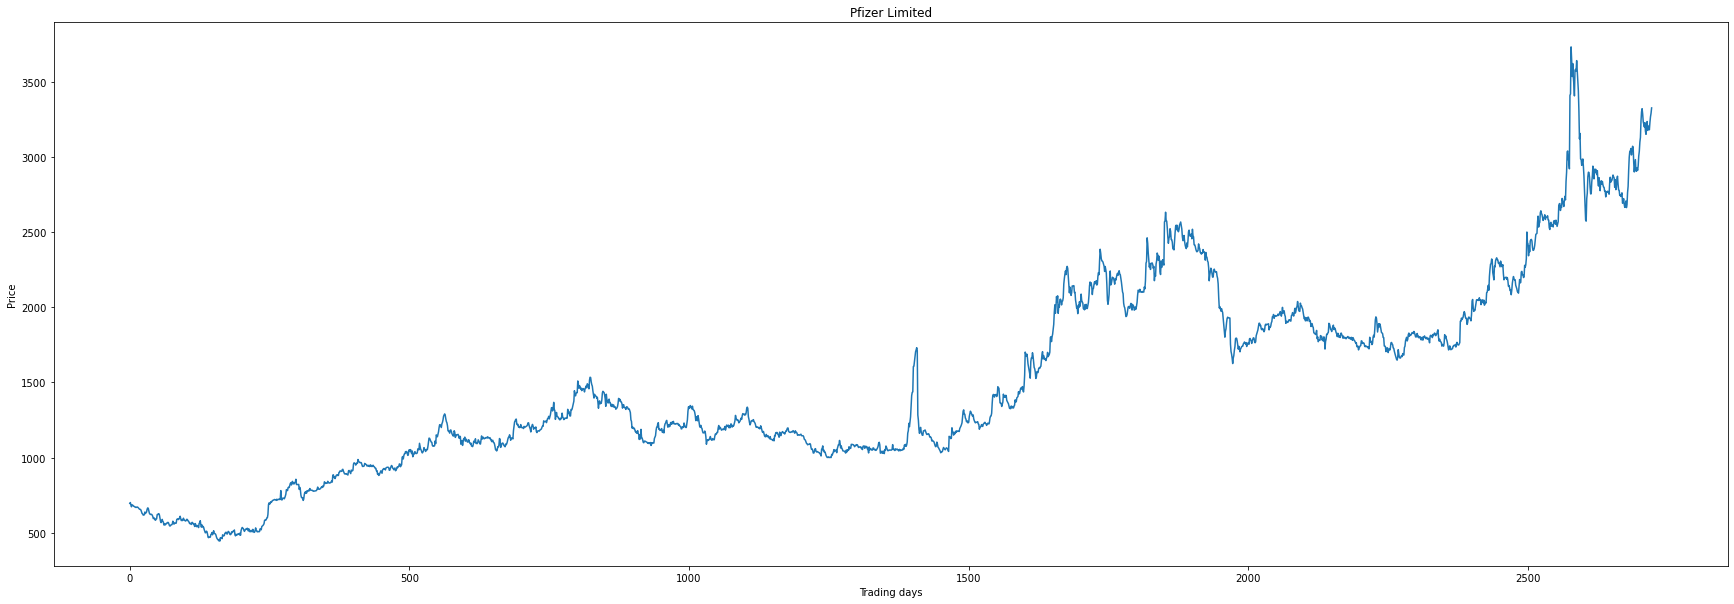

In [49]:
df = pd.read_excel("/home/shravan/Desktop/Datasets/pharma/pfizer/pfizer.xlsx")

print(df.head())
print("\n****\n",df.tail())

print("_________________________________________________________\n\nOPEN \n\tAverage : ",np.mean(df.loc[:]['Open']),"\n\tMaximum : ", np.max(df['Open']),"\n\tMinimum : ", np.min(df['Open']),"\n\tStandard Deviation : ", np.std(df['Open']))
print("\n\nHIGH \n\tAverage : ",np.mean(df.loc[:]['High']),"\n\tMaximum : ", np.max(df['High']),"\n\tMinimum : ", np.min(df['High']),"\n\tStandard Deviation : ", np.std(df['High']))
print("\n\nLOW \n\tAverage : ",np.mean(df.loc[:]['Low']),"\n\tMaximum : ", np.max(df['Low']),"\n\tMinimum : ", np.min(df['Low']),"\n\tStandard Deviation : ", np.std(df['Low']))
print("\n\nCLOSE \n\tAverage : ",np.mean(df.loc[:]['Close']),"\n\tMaximum : ", np.max(df['Close']),"\n\tMinimum : ", np.min(df['Close']),"\n\tStandard Deviation : ", np.std(df['Close']))
print("\n\nVOLUME \n\tAverage : ",np.mean(df.loc[:]['Volume']),"\n\tMaximum : ", np.max(df['Volume']),"\n\tMinimum : ", np.min(df['Volume']),"\n\tStandard Deviation : ", np.std(df['Volume']))

def reverse_data(df):
    date = []
    day = []
    open = []
    high = []
    low = []
    close = []
    volume = []
    for i in range(len(df)-1, -1, -1):
        #day.append((len(df)-1)-i)
        #date.append(df.loc[i]['Date '])
        #open.append(df.loc[i]['Open'])
        #high.append(df.loc[i]['High'])
        #low.append(df.loc[i]['Low'])
        close.append(df.loc[i]['Close'])
        #volume.append(df.loc[i]['Volume'])
    stocks = pd.DataFrame()
    #stocks['Day'] = day
    #stocks['Date'] = date
    #stocks['Open'] = open
    #stocks['High'] = high
    #stocks['Low'] = low
    stocks['Close'] = close
    #stocks['Volume'] = volume
    return stocks

stocks = reverse_data(df)

print(stocks.head())
print("\n****\n",stocks.tail())

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,10)
fig,ax = plt.subplots()

#ax.plot(stocks['Day'],stocks['Close'])
ax.plot(stocks['Close'])
plt.xlabel("Trading days")
plt.ylabel("Price")
plt.title("Pfizer Limited")
plt.show()

      Close
0  0.076263
1  0.077982
2  0.073024
3  0.069466
4  0.073587

****
          Close
2717  0.832342
2718  0.847352
2719  0.858635
2720  0.865676
2721  0.876549


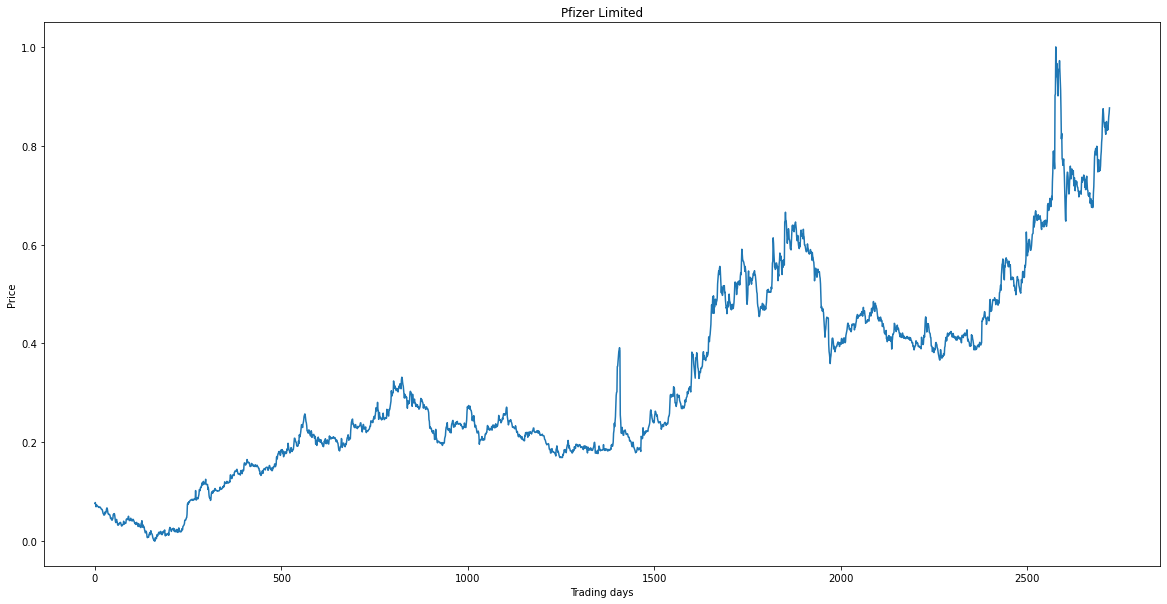

In [50]:
from sklearn.preprocessing import MinMaxScaler

def get_normalised_data(data):
    scaler = MinMaxScaler()
    #numerical = ['Open','High','Low','Close','Volume']
    numerical = ['Close']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

stocks = get_normalised_data(stocks)

print(stocks.head())
print("\n****\n",stocks.tail())

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)
fig,ax = plt.subplots()

#ax.plot(stocks['Day'],stocks['Close'])
ax.plot(stocks['Close'])
plt.xlabel("Trading days")
plt.ylabel("Price")
plt.title("Pfizer Limited")
plt.show()

In [51]:
def unroll(stocks,unroll_length):
    result = []
    for i in range(len(stocks)-unroll_length+1):
        result.append(stocks[i : (i+unroll_length)])
    return np.asarray(result)

def train_test_split(stocks,unroll_length,prediction_size,prediction_time):
    x_test_start = prediction_size + prediction_time + unroll_length - 1
    
    #train data
    x_train = stocks[0 : (-x_test_start - prediction_time)].to_numpy()
    y_train = stocks[ (unroll_length - 1 + prediction_time) : -x_test_start]['Close'].to_numpy()
    
    #test_data
    x_test = stocks[-x_test_start : -prediction_time].to_numpy()
    y_test = stocks[-prediction_size:]['Close'].to_numpy()

    
    return x_train,x_test,y_train,y_test

prediction_size = 494
prediction_time = 5
unroll_length = 50

x_train,x_test,y_train,y_test = train_test_split(stocks,unroll_length,prediction_size,prediction_time)

x_train = unroll(x_train,unroll_length).reshape(2120,50)
x_test = unroll(x_test,unroll_length).reshape(494,50)

x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')


print("x_train", x_train.shape)
#print(x_train[0:2])
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2120, 50)
y_train (2120,)
x_test (494, 50)
y_test (494,)


Using CPU backend.
Training rbm layer 1.
Epoch:1/300 -rbm_train_loss: 14.354
Epoch:2/300 -rbm_train_loss: 14.332
Epoch:3/300 -rbm_train_loss: 14.332
Epoch:4/300 -rbm_train_loss: 14.312
Epoch:5/300 -rbm_train_loss: 14.271
Epoch:6/300 -rbm_train_loss: 14.254
Epoch:7/300 -rbm_train_loss: 14.310
Epoch:8/300 -rbm_train_loss: 14.247
Epoch:9/300 -rbm_train_loss: 14.296
Epoch:10/300 -rbm_train_loss: 14.208
Epoch:11/300 -rbm_train_loss: 14.225
Epoch:12/300 -rbm_train_loss: 14.199
Epoch:13/300 -rbm_train_loss: 14.169
Epoch:14/300 -rbm_train_loss: 14.177
Epoch:15/300 -rbm_train_loss: 14.139
Epoch:16/300 -rbm_train_loss: 14.167
Epoch:17/300 -rbm_train_loss: 14.174
Epoch:18/300 -rbm_train_loss: 14.139
Epoch:19/300 -rbm_train_loss: 14.130
Epoch:20/300 -rbm_train_loss: 14.134
Epoch:21/300 -rbm_train_loss: 14.075
Epoch:22/300 -rbm_train_loss: 14.127
Epoch:23/300 -rbm_train_loss: 14.079
Epoch:24/300 -rbm_train_loss: 14.071
Epoch:25/300 -rbm_train_loss: 14.087
Epoch:26/300 -rbm_train_loss: 14.017
Epoch:

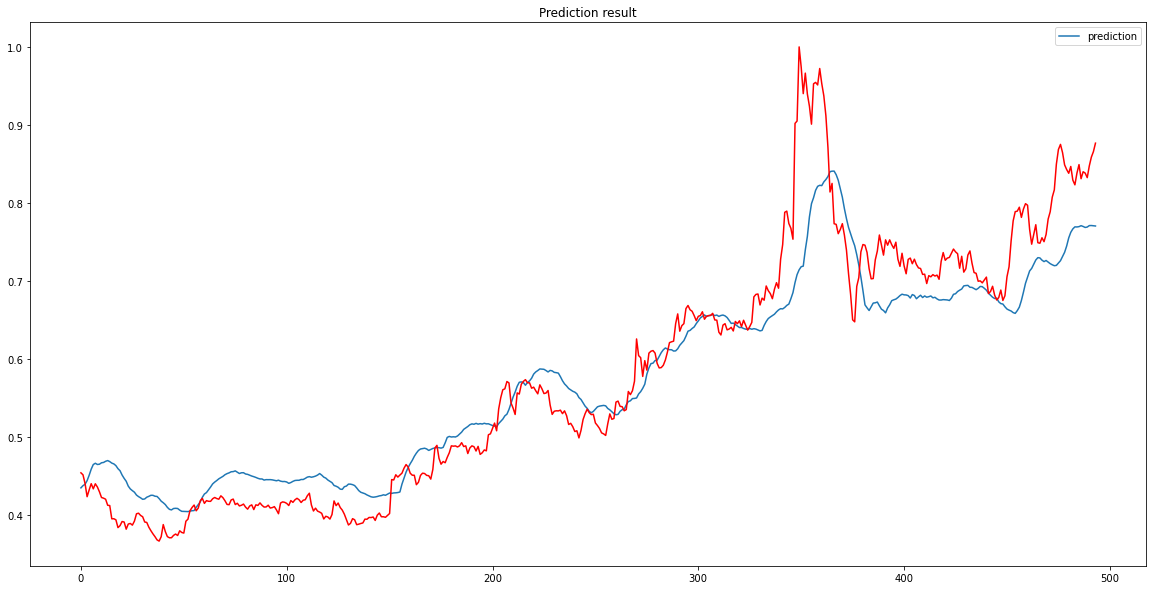

In [52]:
input_length = 50
output_length = 1
test_percentage = 0.2

# network
hidden_units = [40, 40]
device = 'cpu'

if device == 'cuda':
    assert torch.cuda.is_available() is True, "cuda isn't available"
    print('Using GPU backend.\n'
          'GPU type: {}'.format(torch.cuda.get_device_name(0)))
else:
    print('Using CPU backend.')

# train & predict
batch_size = 128
epoch_pretrain = 300
epoch_finetune = 500
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam


dbn = DBN(hidden_units, input_length, output_length, device=device)

# Train model
dbn.pretrain(x_train, epoch=epoch_pretrain, batch_size=batch_size)
dbn.finetune(x_train, y_train, epoch_finetune, batch_size, loss_function, optimizer(dbn.parameters()))

# Make prediction and plot
y_predict = dbn.predict(x_test, batch_size)
#y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
#y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
plt.figure(1)
#plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
plt.plot(y_test,"r-")
#plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
plt.legend()
plt.title('Prediction result')
plt.show()

In [53]:
MSE = sum((y_predict - y_test)**2)/494
MSE

tensor(0.0029, dtype=torch.float64)

In [54]:
RMSE = MSE**0.5
RMSE

tensor(0.0541, dtype=torch.float64)